In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
df1=pd.read_csv('possum_dataset.csv')
df1.head()

,pop,sex,age,head_l,skull_w,tail_l,total_l
0,0,0,8,94.1,60.4,36.0,89.0
1,0,1,6,92.5,57.6,36.5,91.5
2,0,1,6,94.0,60.0,39.0,95.5
3,0,1,6,93.2,57.1,38.0,92.0
4,0,1,2,91.5,56.3,36.0,85.5


In [3]:
#Drop Model Column and Key Statistics
dataset=df1
dataset.describe()

,pop,sex,age,head_l,skull_w,tail_l,total_l
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,0.557692,0.413462,3.817308,92.602885,56.883654,37.009615,87.088462
std,0.499066,0.494839,1.894112,3.573349,3.113426,1.959518,4.310549
min,0.000000,0.000000,1.000000,82.500000,50.000000,32.000000,75.000000
25%,0.000000,0.000000,2.750000,90.675000,54.975000,35.875000,84.000000
50%,1.000000,0.000000,3.000000,92.800000,56.350000,37.000000,88.000000
75%,1.000000,1.000000,5.000000,94.725000,58.100000,38.000000,90.000000
max,1.000000,1.000000,9.000000,103.100000,68.600000,43.000000,96.500000


In [4]:
#Tukey Method

# Import required libraries
from collections import Counter

# Outlier detection 
def detect_outliers(df,n,features):
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# List of Outliers
Outliers_to_drop = detect_outliers(dataset.drop('total_l',axis=1),0,list(dataset.drop('total_l',axis=1)))
dataset.drop('total_l',axis=1).loc[Outliers_to_drop]

,pop,sex,age,head_l,skull_w,tail_l
8,0,1,9,93.4,56.3,37.0
10,0,1,9,93.3,57.2,39.0
54,1,0,2,103.1,63.2,38.0
58,1,0,2,102.5,62.8,40.0
72,1,0,1,82.5,52.3,36.5
16,0,1,1,94.7,67.7,36.5
47,1,0,5,98.6,63.2,34.0
53,1,0,7,96.9,63.0,43.0
57,1,0,3,94.5,64.2,39.0
78,1,0,1,85.8,50.0,36.5


In [5]:
#Create New Dataset without Outliers
good_data = dataset.drop(dataset.index[Outliers_to_drop]).reset_index(drop = True)
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pop      90 non-null     int64  
 1   sex      90 non-null     int64  
 2   age      90 non-null     int64  
 3   head_l   90 non-null     float64
 4   skull_w  90 non-null     float64
 5   tail_l   90 non-null     float64
 6   total_l  90 non-null     float64
dtypes: float64(4), int64(3)
memory usage: 5.0 KB


In [6]:
#Create Standard Model

#Define x and y variable
x = good_data.drop('total_l',axis=1).to_numpy()
y = good_data['total_l'].to_numpy()

#Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [7]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_lm = Pipeline([('scl', StandardScaler()),
                    ('clf', LinearRegression())])
pipeline.insert(0,pipe_lm)

pipe_lasso= Pipeline([('scl', StandardScaler()),
                     ('clf', Lasso(random_state=100))])
pipeline.insert(1,pipe_lasso)

pipe_ridge= Pipeline([('scl', StandardScaler()),
                     ('clf', Ridge(random_state=100))])
pipeline.insert(2,pipe_ridge)

pipe_elas= Pipeline([('scl', StandardScaler()),
                     ('clf', ElasticNet(random_state=100))])
pipeline.insert(3,pipe_elas)

# Set grid search params 

modelpara =[]

param_gridlm = {}
modelpara.insert(0,param_gridlm)

param_gridlasso = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20],
                  'clf__tol':[1e-1, 1, 5, 10, 20, 50, 100]}
modelpara.insert(1,param_gridlasso)

param_gridridge = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20],
                  'clf__tol':[1e-1, 1, 5, 10, 20, 50, 100]}
modelpara.insert(2,param_gridridge)

param_gridelas = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20],
                 'clf__tol':[1e-1, 1, 5, 10, 20, 50, 100]}
modelpara.insert(3,param_gridelas)

In [8]:
#Create Learning Curves

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes=np.linspace(.1,1,10),
                                                            scoring = 'neg_root_mean_squared_error',
                                                            cv=10,random_state=100)
    
    train_mean = np.sqrt(np.mean(-train_scores, axis=1))
    train_std = np.sqrt(np.std(-train_scores, axis=1))
    test_mean = np.sqrt(np.mean(-test_scores, axis=1))
    test_std = np.sqrt(np.std(-test_scores, axis=1))
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('RMSE')
    plt.legend(loc='best')
    plt.ylim([-1,10])
    plt.show()

Learning Curve - LM


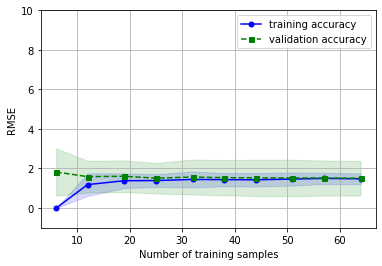

Learning Curve - Lasso


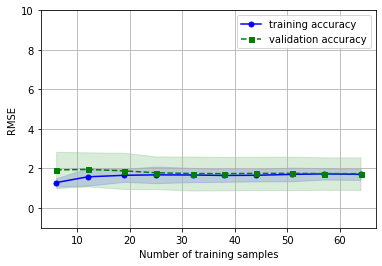

Learning Curve - Ridge


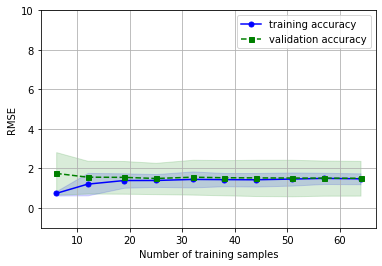

Learning Curve - ElasticNet


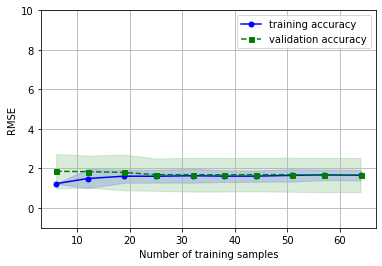

In [9]:
#Plot Learning Curve

print('Learning Curve - LM')
plot_learning_curves(pipe_lm)
print('Learning Curve - Lasso')
plot_learning_curves(pipe_lasso)
print('Learning Curve - Ridge')
plot_learning_curves(pipe_ridge)
print('Learning Curve - ElasticNet')
plot_learning_curves(pipe_elas)

Model Evaluation - RMSE
LinearRegression 1.53
Lasso 1.73
Ridge 1.53
ElasticNet 1.67




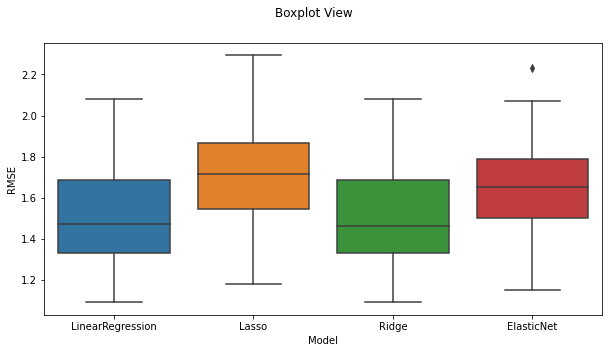

In [10]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('LinearRegression',pipe_lm))
models.append(('Lasso',pipe_lasso))
models.append(('Ridge',pipe_ridge))
models.append(('ElasticNet',pipe_elas))
  
#Model Evaluation
results =[]
names=[]
scoring ='neg_root_mean_squared_error'
print('Model Evaluation - RMSE')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train,y_train,cv=rkf,scoring=scoring)
    results.append(np.sqrt(-cv_results))
    names.append(name)
    print('{} {:.2f}'.format(name,np.sqrt(-cv_results.mean())))
print('\n')

#Boxplot View
fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()

In [11]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn import metrics

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='neg_root_mean_squared_error')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
   
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    print('\nBest Parameters:',bestpara)
    
    #Test data accuracy of model with best params    
    print('\nIntercept: {:.2f}'.format(float(gs_clf.best_estimator_.named_steps['clf'].intercept_)))
    print('\nModel coefficients: ')   
    for name, score in zip(list(good_data.drop('total_l',axis=1)),
                           gs_clf.best_estimator_.named_steps['clf'].coef_):
         print(name, round(score,2)) 
    
    #Print R2
    print('\nR2: {:0.2f}'.format(metrics.r2_score(y_test,y_pred)))
    adjusted_r_squared2 = 1-(1-metrics.r2_score(y_test,y_pred))*(len(y)-1)/(len(y)-x.shape[1]-1)
    print('Adj_R2: {:0.2f}'.format(adjusted_r_squared2))        
      
    #Print MSE and RMSE
    print('\nMean Absolute Error: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))  
    print('Mean Squared Error: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))  
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))) 

In [12]:
#Run Models
for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: LinearRegression()

Best Parameters: {}

Intercept: 87.25

Model coefficients: 
pop -1.38
sex 0.75
age -0.15
head_l 1.72
skull_w 0.63
tail_l 2.04

R2: 0.76
Adj_R2: 0.75

Mean Absolute Error: 1.75
Mean Squared Error: 4.40
Root Mean Squared Error: 2.10

Optimized Model

Model Name: Lasso(random_state=100)

Best Parameters: {'clf__alpha': 0.1, 'clf__tol': 0.1}

Intercept: 87.25

Model coefficients: 
pop -1.04
sex 0.72
age -0.0
head_l 1.66
skull_w 0.64
tail_l 1.74

R2: 0.73
Adj_R2: 0.71

Mean Absolute Error: 1.87
Mean Squared Error: 4.98
Root Mean Squared Error: 2.23

Optimized Model

Model Name: Ridge(random_state=100)

Best Parameters: {'clf__alpha': 5, 'clf__tol': 0.1}

Intercept: 87.25

Model coefficients: 
pop -1.15
sex 0.74
age -0.1
head_l 1.58
skull_w 0.74
tail_l 1.77

R2: 0.74
Adj_R2: 0.72

Mean Absolute Error: 1.85
Mean Squared Error: 4.89
Root Mean Squared Error: 2.21

Optimized Model

Model Name: ElasticNet(random_state=100)

Best Parameters: {'clf_